# Final Project CSCA 5642 Introduction to Deep Learning CU Boulder
## Analyzing Chaotic Systems with Deep Learning
### Introduction
One of the key hallmarks of chaotic systems is "sensitive dependence to initial conditions." To illustrate this with an example, say that you were able to collect an arbitrary number of variables (barometric pressure, temperature, moisture) at each point in the atmosphere to an arbitrary precision. Assuming you were then able to construct the correct models for weather and crunch them in a super computer, would you be able to then predict the weather in Temecula for December 3rd of next year?  
*The answer is no!*  
To understand why is beyond the scope of this project. But in short, say one of your variables is temperature, and say you round out your measurement to the millionth of a degree. Well, who is to say the temperature cannot be as precise as the ten millionth of a degree? At this point we may get into an argument of physics, but you get the point, no matter how arbitrarily accurate your record is, reality can be more so. In that tiny bit of mismeasurement, no matter how close you are to measuring the trajectory of a chaotic system, a few time steps down the line you and the chaotic system will have diverged. More time steps down the line, and you are no longer near each other at all.  
### Relation to Deep Learning  
Neural networks are universal function approximators, [\[1\]](https://www.cs.cmu.edu/~epxing/Class/10715/reading/Kornick_et_al.pdf), thus:
For any function, $f$, and a criteria of closeness, ${\epsilon} > 0$, if there are enough neurons in a neural network, there exists a neural network with that many neurons that does approximate $f$ to within ${\epsilon}$.  
But, there is no guarantee of the size needed. That question, the size needed, is what we are going to explore with the Lorenz System. 
### Calculating ${\epsilon}$
Before we talked of the divergence of the hypothetically accurate weather model and the "true" chaotic weather system. Is there a way to measure this divergence?
${\lambda}(x_0)=lim_{n->{\inf}} (1/n){\sum}(ln|f'(x_i)|)$  from $i=0$ to $n-1$ will yield the "maximal" lyapunov exponent over a series of data.     
However, we are not going to do that. Instead, we are going to spoof this parameter by simply finding the average distance between actual data and predicted data.
### Motivations
Much of deep learning and neural network architectures in general is seen as black magic, even by experts. We are not really sure much of the time what or how these systems are learning (at least in the sense of what features data relations they are performing), and much of the time they are treated as black boxes. At the same time, hyper parameter tuning is very much still an 'empirical' endeavor. (see Andrew Ng's course and many others endeavor. From the outside, empirical just seems to mean mucking about in the dark seeing what works (shuffling the ML system until the data looks right), though a more generous interpretation is its an intuition gained over experience. Either way, that is not very satisfying from an engineering or scientific perspective.  
What we do know and understand fairly well is dynamical systems. There is much mathematical literature on complex, nonlinear, and/or chaotic systems at least in 3 dimensions and a plethora of engineering use cases for this knowledge. Since neural networks are not just universal approximation functions, but also a kind of native dynamical system in and of themselves, if we point these black boxes at understood dynamical systems perhaps we can learn more about them. On one hand, we have transparent and measurable dynamical systems, and on the other, our opaque NN system, and by sharpening them against each other there could be many insights. The future opportunties for understanding NN's in this way and using them to help us further work with even higher, nonlinear systems is absolutely staggering and could open up an entire new way of understanding impossibly complex systems such as economies, ecologies, climate, etc.  
### Goals
This project is not attempting to create the best Lorenz system predictor. Instead, I am hoping to motivate some interesting questions around the architecture and parameter tuning of NN's and glean some insight into what a well understood but rich dynamical system can tell us about NN's. There are some unexpected results along the way, and I am hoping the questions raise provoke interest and further exploration into this area.

### Outline
- 1. Imports and Helper Functions
    - Make sure our GPU is registered by tf
    - Helper functions
    - LorenzSystem class for our ground truth system
    - Our DL model
- 2. Single Layer Model
- 3. Multi-Layer Model
- 4. Multi, Larger-Layer Model
- 5. More Data
- 6. RNN
  8. Workstation Fire-Hazard RNN, Tons of Data
- 9. Comparisons
- 10. Conclusion

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statistics
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [41]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [42]:
def euclidean_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.linalg.norm(point2 - point1)

In [43]:
class LorenzSystem:
    def __init__(self, sigma=10, rho=28, beta=8/3, dt=0.01):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt
        self.results = []

    def step(self, state):
        x, y, z = state
        dx = self.sigma * (y - x) * self.dt
        dy = (x * (self.rho - z) - y) * self.dt
        dz = (x * y - self.beta * z) * self.dt
        return [x + dx, y + dy, z + dz]

    def simulate(self, initial_state, num_steps):
        states = [initial_state]
        for _ in range(num_steps):
            states.append(self.step(states[-1]))
        return np.array(states)

    def plot(self):
        states = self.results
        if len(states) == 0:
            return
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(states[:, 0], states[:, 1], states[:, 2])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Discrete Lorenz System')
        plt.show()

    def run_simulation(self, initial_state, num_steps):
        self.results = self.simulate(initial_state, num_steps)
        return self.results

    def jacobian_eigenvalues(self, point):
        x, y, z = point
        # Define the Jacobian matrix at the given point
        J = np.array([
            [-self.sigma, self.sigma, 0],
            [self.rho - z, -1, -x],
            [y, x, -self.beta]
        ])
        # Calculate the eigenvalues
        eigenvalues = np.linalg.eigvals(J)
        return eigenvalues

In [44]:
## Constants
INITIAL_STATE = [1,1,1]
TRAINING_SET_SIZE = 10000

In [45]:
lorenz = LorenzSystem(rho=28)
states = lorenz.run_simulation(INITIAL_STATE, TRAINING_SET_SIZE+1000)
training_set = states[:10000]
test_set = states[10000:]

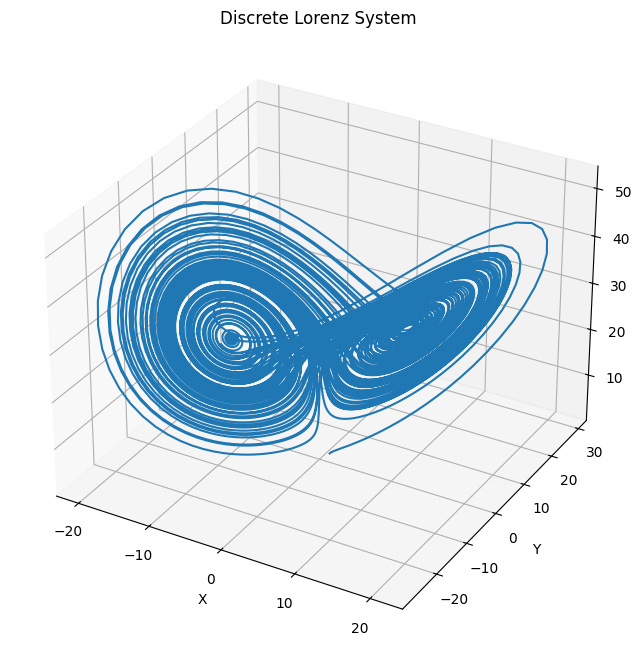

In [46]:
lorenz.plot()

In [47]:
class LorenzPredictor:
    def __init__(self, hidden_layer_sizes=[8], activations=['relu']):
        if len(hidden_layer_sizes) != len(activations):
            raise ValueError("The length of hidden_layer_sizes and activations must be the same.")
        
        self.model = Sequential()
        self.model.add(Dense(hidden_layer_sizes[0], activation=activations[0], input_shape=(3,)))
        
        for size, activation in zip(hidden_layer_sizes[1:], activations[1:]):
            self.model.add(Dense(size, activation=activation))
        
        self.model.add(Dense(3))  # Output layer
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])


    def prepare_data(self, states):
        X = states[:-1]
        y = states[1:]
        return X, y

    def train(self, states, epochs=100, batch_size=32):
        X, y = self.prepare_data(states)
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)
        return history

    def predict_next_state(self, current_state):
        return self.model.predict(np.array([current_state]))[0]
    
    def generate_predictions(self, initial_state, num_predictions):
        predictions = [initial_state]
        for _ in range(num_predictions):
            next_state = self.predict_next_state(predictions[-1])
            predictions.append(next_state)
        return np.array(predictions)
        
    def plot_training_history(self, history):
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(122)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

#### Single Layer Model

In [48]:
single_layer_model = LorenzPredictor(hidden_layer_sizes=[8], activations=["relu"])
single_layer_model.model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59 (236.00 B)

 Trainable params: 59 (236.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
single_layer_history = single_layer_model.train(training_set)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 239.0344 - mae: 11.9943 - val_loss: 31.5526 - val_mae: 4.2551
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.0740 - mae: 2.6429 - val_loss: 2.4939 - val_mae: 1.0101
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0075 - mae: 0.8989 - val_loss: 1.5517 - val_mae: 0.8386
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4158 - mae: 0.7719 - val_loss: 1.0771 - val_mae: 0.7167
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0035 - mae: 0.6629 - val_loss: 0.7208 - val_mae: 0.5985
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6317 - mae: 0.5392 - val_loss: 0.4867 - val_mae: 0.5103
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4557 - mae: 0.4619 - val_loss: 0.3472 - val_mae: 0.4281
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3935 - mae: 0.3998 - val_loss: 0.2773 - val_mae: 0.3877
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s

In [53]:
test_state = test_set[0]
predicted_next_state = single_layer_model.predict_next_state(test_state)
#actual_next_state = lorenz.step(test_state)

print("Predicted next state:", predicted_next_state)
print("Actual next state:", test_state)
print(f"Deviation at first prediction: {euclidean_distance(predicted_next_state, test_state)}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted next state: [ 6.8977757  7.3937836 24.367094 ]
Actual next state: [ 6.84845379  7.27920934 24.39715361]
Deviation at first prediction: 0.12831008220564277


##### An interesting note about the loss
We see in our model training that our loss at the end was ~0.0393. This is the mean squared error (MSE) across the entire epoch measuring the difference between the input coordinates and the output coordinates. At the end, we measure the deviation starting at the very first prediction where the model is "on its own." Since these measures are so transparent, it is provocative to imagine a better way of calculating the loss or analyzing it against our deviations at the end.

In [54]:
num_predictions = 1000
single_layer_next_1000_predictions = single_layer_model.generate_predictions(training_set[0], num_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [55]:
final_point_model = single_layer_next_1000_predictions[-1]
final_point_actual = test_set[-1]
print(f"Deviation by point {num_predictions}: {euclidean_distance(final_point_model, final_point_actual)}") 

Deviation by point 1000: 38.24325123752788


In [59]:
growth = euclidean_distance(final_point_model, final_point_actual) - euclidean_distance(predicted_next_state, test_state)
print(f"Deviation grew by {growth} in {num_predictions} iterations")

Deviation grew by 38.114941155322235 in 1000 iterations


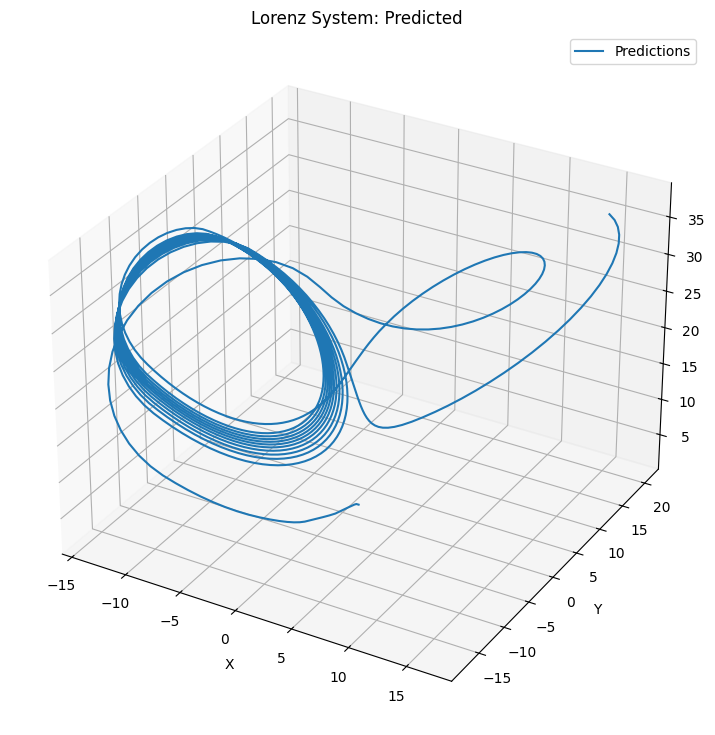

In [60]:
# Plot the predictions
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(single_layer_next_1000_predictions[:, 0], single_layer_next_1000_predictions[:, 1], single_layer_next_1000_predictions[:, 2], label='Predictions')
#ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Predicted')
ax.legend()
plt.show()

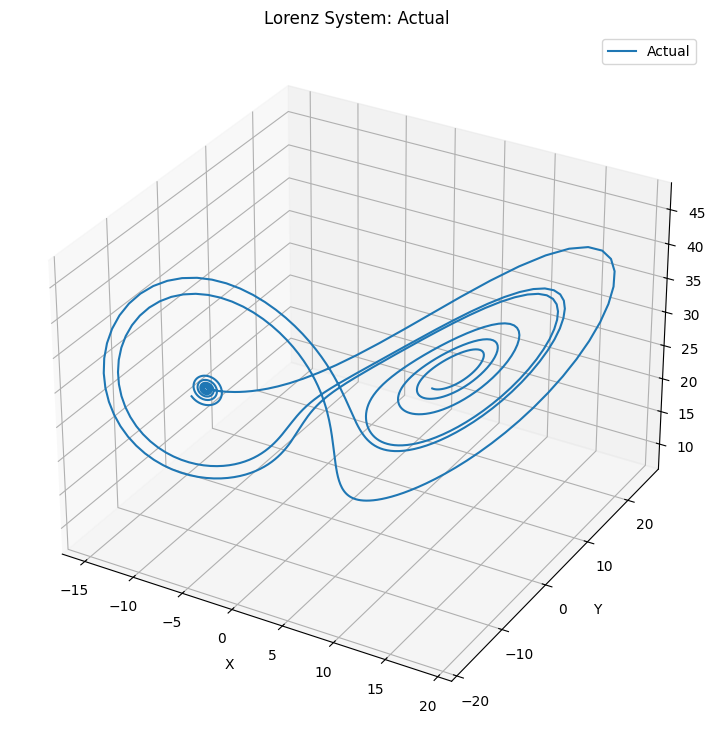

In [61]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Actual')
ax.legend()
plt.show()

### Deeper Model

In [63]:
deeper_model = LorenzPredictor(hidden_layer_sizes=[8,8,8], activations=["relu", "relu","relu"])
deeper_model.model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203 (812.00 B)

 Trainable params: 203 (812.00 B)

 Non-trainable params: 0 (0.00 B)

In [64]:
deeper_history = deeper_model.train(training_set)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 223.8423 - mae: 11.6486 - val_loss: 7.9077 - val_mae: 2.0342
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0871 - mae: 1.5217 - val_loss: 2.3534 - val_mae: 1.0757
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8243 - mae: 0.9194 - val_loss: 1.0239 - val_mae: 0.7238
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9280 - mae: 0.6795 - val_loss: 0.5327 - val_mae: 0.5516
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5204 - mae: 0.5242 - val_loss: 0.3341 - val_mae: 0.4333
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3624 - mae: 0.4294 - val_loss: 0.3082 - val_mae: 0.4209
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2993 - mae: 0.3806 - val_loss: 0.2085 - val_mae: 0.3201
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2297 - mae: 0.3257 - val_loss: 0.2414 - val_mae: 0.3447
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [65]:
test_state = test_set[0]
predicted_next_state = deeper_model.predict_next_state(test_state)
#actual_next_state = lorenz.step(test_state)

print("Predicted next state:", predicted_next_state)
print("Actual next state:", test_state)
print(f"Deviation at first prediction: {euclidean_distance(predicted_next_state, test_state)}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted next state: [ 6.8957095  7.323844  24.330011 ]
Actual next state: [ 6.84845379  7.27920934 24.39715361]
Deviation at first prediction: 0.09345283862231632


In [66]:
num_predictions = 1000
deeper_next_1000_predictions = deeper_model.generate_predictions(training_set[0], num_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [67]:
final_point_model_deeper = deeper_next_1000_predictions[-1]
final_point_actual = test_set[-1]
print(f"Deviation by point {num_predictions}: {euclidean_distance(final_point_model_deeper, final_point_actual)}") 

Deviation by point 1000: 16.84711321916309


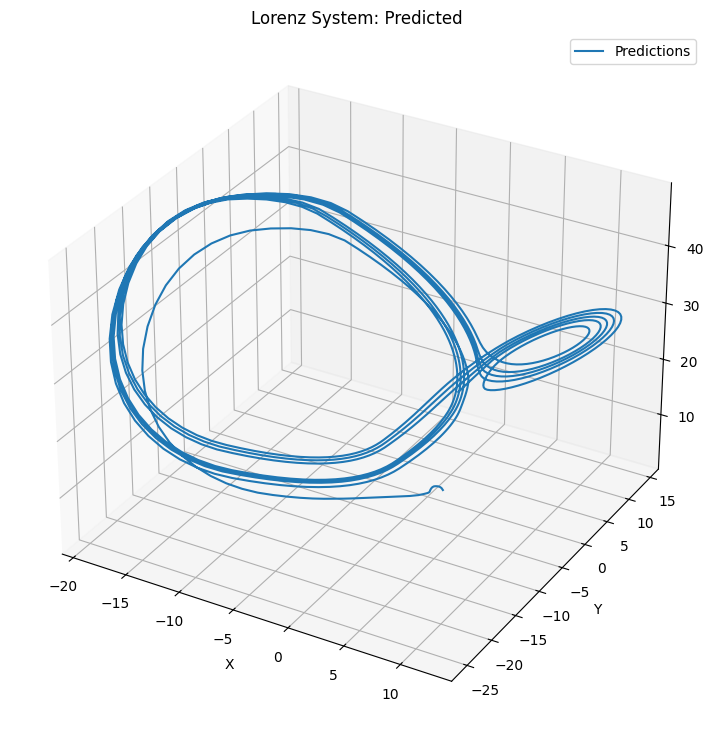

In [68]:
# Plot the predictions
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(deeper_next_1000_predictions[:, 0], deeper_next_1000_predictions[:, 1], deeper_next_1000_predictions[:, 2], label='Predictions')
#ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Predicted')
ax.legend()
plt.show()

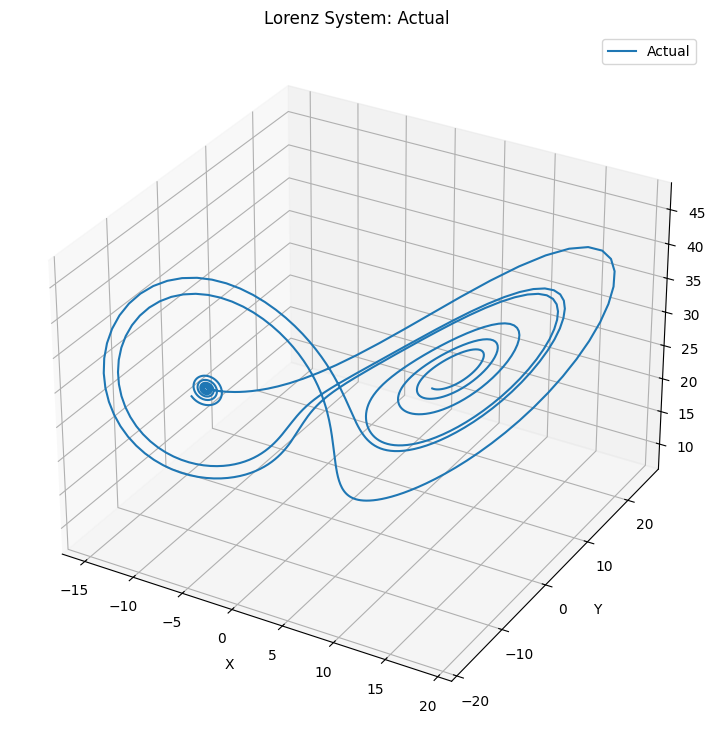

In [69]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Actual')
ax.legend()
plt.show()

#### Multi-Larger Layer Model

In [70]:
multi_larger_model = LorenzPredictor(hidden_layer_sizes=[32,64,32], activations=["relu", "relu","relu"])
multi_larger_model.model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419 (17.26 KB)

 Trainable params: 4,419 (17.26 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
multi_larger_history = multi_larger_model.train(training_set)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 69.3726 - mae: 4.9375 - val_loss: 0.1992 - val_mae: 0.3282
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1402 - mae: 0.2582 - val_loss: 0.0765 - val_mae: 0.1909
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0849 - mae: 0.1971 - val_loss: 0.0523 - val_mae: 0.1721
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0580 - mae: 0.1619 - val_loss: 0.0418 - val_mae: 0.1446
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0470 - mae: 0.1404 - val_loss: 0.0417 - val_mae: 0.1446
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0395 - mae: 0.1283 - val_loss: 0.0277 - val_mae: 0.1147
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0329 - mae: 0.1147 - val_loss: 0.0211 - val_mae: 0.1048
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0296 - mae: 0.1098 - val_loss: 0.0161 - val_mae: 0.0921
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

In [72]:
test_state = test_set[0]
predicted_next_state = multi_larger_model.predict_next_state(test_state)
#actual_next_state = lorenz.step(test_state)

print("Predicted next state:", predicted_next_state)
print("Actual next state:", test_state)
print(f"Deviation at first prediction: {euclidean_distance(predicted_next_state, test_state)}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted next state: [ 6.90745    7.3608384 24.191038 ]
Actual next state: [ 6.84845379  7.27920934 24.39715361]
Deviation at first prediction: 0.22940678453907268


In [73]:
num_predictions = 1000
multi_larger_next_1000_predictions = multi_larger_model.generate_predictions(training_set[0], num_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [74]:
final_point_model_multi_larger = multi_larger_next_1000_predictions[-1]
final_point_actual = test_set[-1]
print(f"Deviation by point {num_predictions}: {euclidean_distance(final_point_model_multi_larger, final_point_actual)}") 

Deviation by point 1000: 24.47957866116457


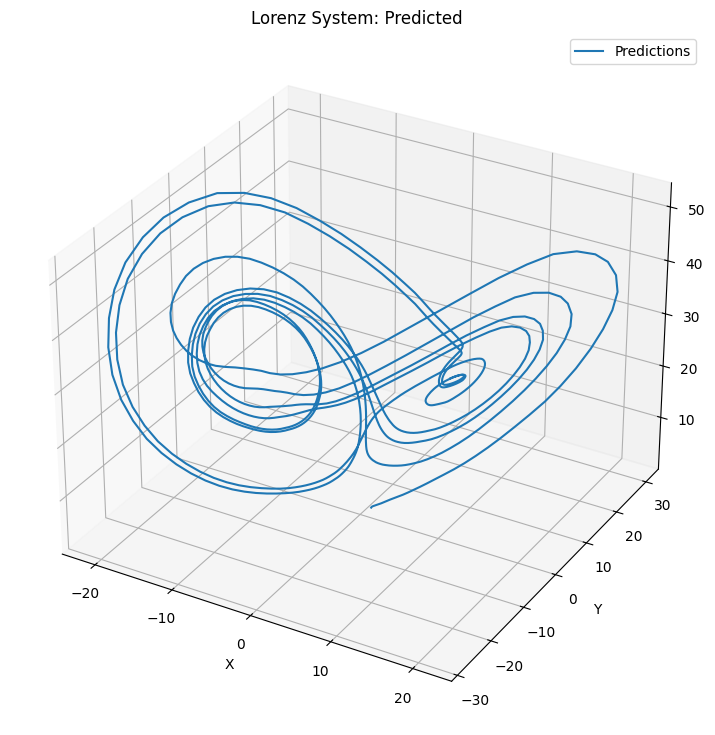

In [75]:
# Plot the predictions
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(multi_larger_next_1000_predictions[:, 0], multi_larger_next_1000_predictions[:, 1], multi_larger_next_1000_predictions[:, 2], label='Predictions')
#ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Predicted')
ax.legend()
plt.show()

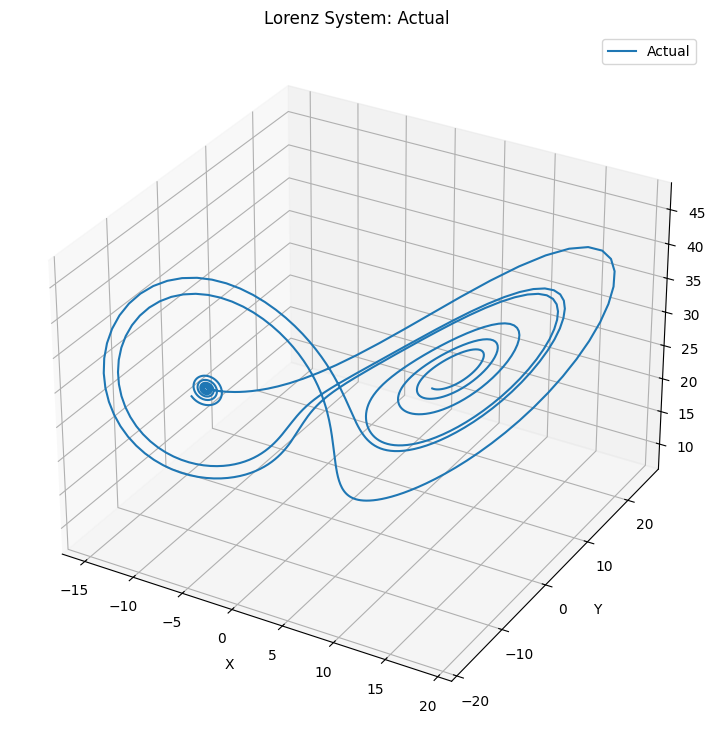

In [76]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Actual')
ax.legend()
plt.show()

##### Unexpected Result
The deeper, larger model performed worse, even though the end loss function was far smaller than for the other models. At this point, we have multiple jump off points for what to try here.  
A few hypotheses:  
- More training
    - Since the model is so much larger, perhaps it just needs a larger data set. That is easy to test, and we will try it
- Data normalization
    - There are probably some gains to be made by normalizing or otherwise reformatting our data. This will not be explored here.  
- More nodes isn't helping, but more layers could
    - Hyper parameter tuning is more art than science at this point. Maybe there is something interesting going on where this chaotic system is better approximated by more layers and not more nodes - we will not try this but leave it for future exploration
-  Activation functions
    - Again, more art than science. Might be worth trying a different activation function. We are not going to explore this on this project because I have no idea how to interpret it
- Recurrence
    - Since this is time series data, maybe some history would help us. We will try RNN's and see how they perform  
A few other questions:
- What does the progression of loss tell us about the training? If loss plateaus, would we be better served with more nodes or more layers, or a combination of both?

#### More Data

In [79]:
LARGER_SET_SIZE = TRAINING_SET_SIZE * 2 
lorenz_2 = LorenzSystem(rho=28)
states = lorenz_2.run_simulation(INITIAL_STATE, LARGER_SET_SIZE+1000)
training_set = states[:LARGER_SET_SIZE]
test_set = states[LARGER_SET_SIZE:]

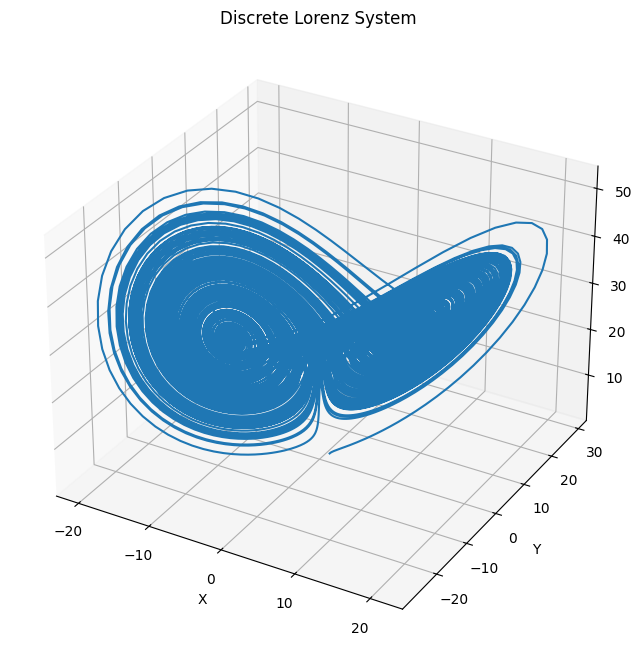

In [80]:
lorenz_2.plot()

In [81]:
multi_larger_model = LorenzPredictor(hidden_layer_sizes=[32,64,32], activations=["relu", "relu","relu"])
multi_larger_model.model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419 (17.26 KB)

 Trainable params: 4,419 (17.26 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
multi_larger_history = multi_larger_model.train(training_set)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 34.7408 - mae: 2.9821 - val_loss: 0.0511 - val_mae: 0.1612
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0581 - mae: 0.1610 - val_loss: 0.0279 - val_mae: 0.1069
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0332 - mae: 0.1186 - val_loss: 0.0196 - val_mae: 0.1037
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0211 - mae: 0.0966 - val_loss: 0.0124 - val_mae: 0.0814
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162 - mae: 0.0848 - val_loss: 0.0102 - val_mae: 0.0766
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - mae: 0.0762 - val_loss: 0.0063 - val_mae: 0.0587
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - mae: 0.0781 - val_loss: 0.0139 - val_mae: 0.0953
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - mae: 0.0753 - val_loss: 0.0078 - val_mae: 0.0676
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms

In [83]:
test_state = test_set[0]
predicted_next_state = multi_larger_model.predict_next_state(test_state)
#actual_next_state = lorenz.step(test_state)

print("Predicted next state:", predicted_next_state)
print("Actual next state:", test_state)
print(f"Deviation at first prediction: {euclidean_distance(predicted_next_state, test_state)}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted next state: [ -8.632024 -12.401035  21.011206]
Actual next state: [ -8.22730471 -11.93780937  20.58708421]
Deviation at first prediction: 0.7471645325169438


In [84]:
num_predictions = 1000
multi_larger_next_1000_predictions = multi_larger_model.generate_predictions(training_set[0], num_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [85]:
final_point_model_multi_larger = multi_larger_next_1000_predictions[-1]
final_point_actual = test_set[-1]
print(f"Deviation by point {num_predictions}: {euclidean_distance(final_point_model_multi_larger, final_point_actual)}") 

Deviation by point 1000: 14.987280261703777


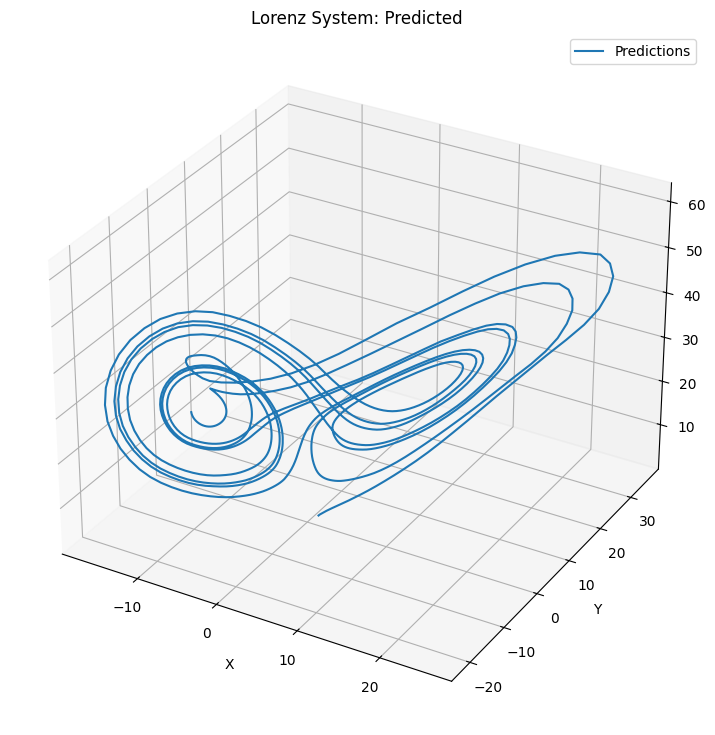

In [86]:
# Plot the predictions
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(multi_larger_next_1000_predictions[:, 0], multi_larger_next_1000_predictions[:, 1], multi_larger_next_1000_predictions[:, 2], label='Predictions')
#ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Predicted')
ax.legend()
plt.show()

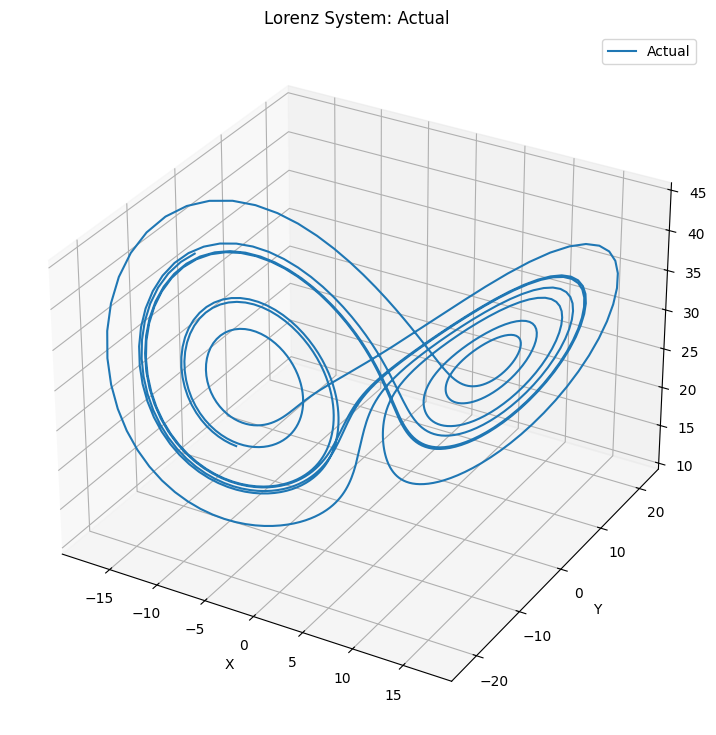

In [87]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Actual')
ax.legend()
plt.show()

##### More Data Conclusion
That definitely helped. But that isn't to say it wouldn't have helped the other models just as much. A lot of interesting behavior to study, but lets continue.

#### RNN

In [99]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

class RNNLorenzPredictor:
    def __init__(self):
        self.model = Sequential([
            LSTM(8, activation='tanh', input_shape=(1, 3), return_sequences=True),
            LSTM(8, activation='tanh'),
            Dense(3)
        ])
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    def prepare_data(self, states):
        # Reshape data to (samples, timesteps, features)
        X = np.array(states[:-1]).reshape(-1, 1, 3)
        y = np.array(states[1:])
        return X, y

    def train(self, states, epochs=100, batch_size=32):
        X, y = self.prepare_data(states)
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)
        return history

    def predict_next_state(self, current_state):
        current_state = np.array(current_state).reshape(1, 1, 3)
        return self.model.predict(current_state)[0]
    
    def generate_predictions(self, initial_state, num_predictions):
        predictions = [initial_state]
        for _ in range(num_predictions):
            next_state = self.predict_next_state(predictions[-1])
            predictions.append(next_state)
        return np.array(predictions)

In [100]:
rnn_model = RNNLorenzPredictor()
rnn_model.model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 1, 8)           │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 955 (3.73 KB)

 Trainable params: 955 (3.73 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
rnn_history = rnn_model.train(training_set)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 262.2136 - mae: 12.9397 - val_loss: 178.0125 - val_mae: 11.0415
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 166.8057 - mae: 10.6398 - val_loss: 137.6688 - val_mae: 9.8962
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 130.2160 - mae: 9.4881 - val_loss: 111.5555 - val_mae: 9.0055
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 108.0767 - mae: 8.6899 - val_loss: 92.8570 - val_mae: 8.2452
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 89.9118 - mae: 7.9639 - val_loss: 79.0457 - val_mae: 7.5546
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 76.0627 - mae: 7.2571 - val_loss: 65.3019 - val_mae: 6.7489
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 62.4263 - mae: 6.4143 - val_loss: 51.9404 - val_mae: 5.9071
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 49.0277 - mae: 5.5454 - val_loss: 39.7037 - val_mae: 4.9796
Epoch 9/100
500/500 ━━

In [102]:
test_state = test_set[0]
predicted_next_state = rnn_model.predict_next_state(test_state)
#actual_next_state = lorenz.step(test_state)

print("Predicted next state:", predicted_next_state)
print("Actual next state:", test_state)
print(f"Deviation at first prediction: {euclidean_distance(predicted_next_state, test_state)}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted next state: [ -8.502026  -12.3057995  20.997433 ]
Actual next state: [ -8.22730471 -11.93780937  20.58708421]
Deviation at first prediction: 0.6158524056786626


In [103]:
num_predictions = 1000
rnn_next_1000_predictions = rnn_model.generate_predictions(training_set[0], num_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [104]:
final_point_rnn = rnn_next_1000_predictions[-1]
final_point_actual = test_set[-1]
print(f"Deviation by point {num_predictions}: {euclidean_distance(final_point_rnn, final_point_actual)}") 

Deviation by point 1000: 33.7678256317611


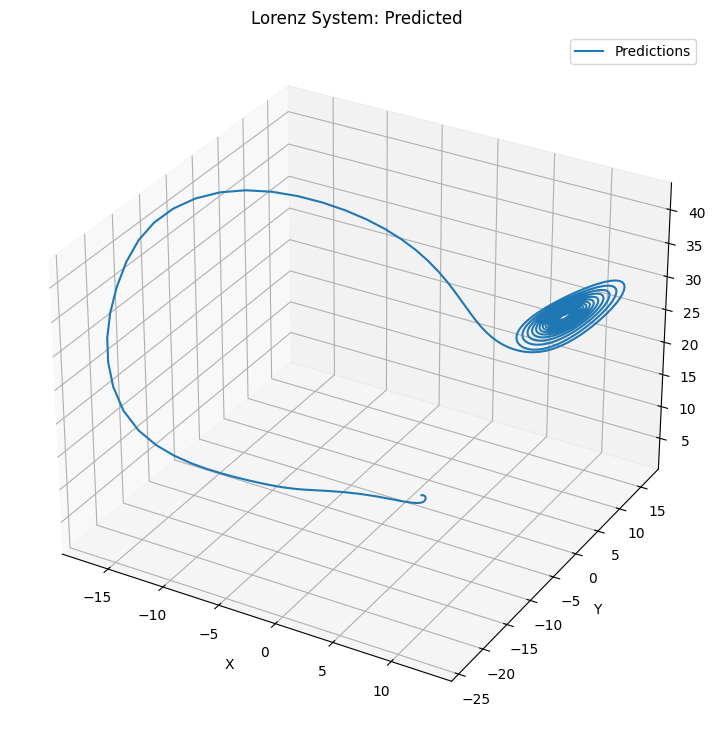

In [105]:
# Plot the predictions
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(rnn_next_1000_predictions[:, 0], rnn_next_1000_predictions[:, 1], rnn_next_1000_predictions[:, 2], label='Predictions')
#ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Predicted')
ax.legend()
plt.show()

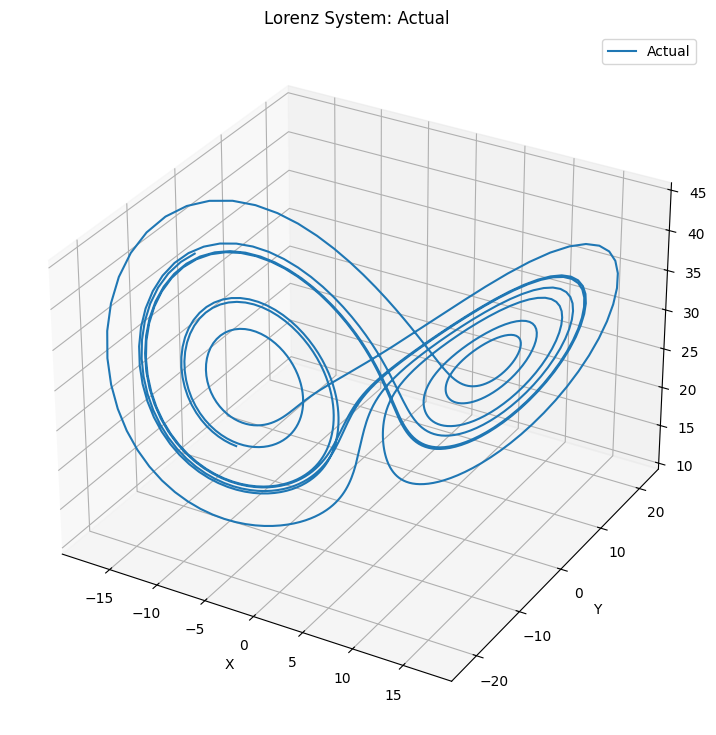

In [106]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Actual')
ax.legend()
plt.show()

##### Unexpected Result
I am not at all sure what happened here. The RNN generated a very interesting and detailed right hand side of the Lorenz system. Overall the performance is horrible.

#### Large RNN, Tons of Data

In [116]:
class RNNLorenzPredictor_Large:
    def __init__(self):
        self.model = Sequential([
            LSTM(50, activation='tanh', input_shape=(1, 3), return_sequences=True),
            LSTM(50, activation='tanh'),
            Dense(3)
        ])
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    def prepare_data(self, states):
        # Reshape data to (samples, timesteps, features)
        X = np.array(states[:-1]).reshape(-1, 1, 3)
        y = np.array(states[1:])
        return X, y

    def train(self, states, epochs=100, batch_size=32):
        X, y = self.prepare_data(states)
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)
        return history

    def predict_next_state(self, current_state):
        current_state = np.array(current_state).reshape(1, 1, 3)
        return self.model.predict(current_state)[0]
    
    def generate_predictions(self, initial_state, num_predictions):
        predictions = [initial_state]
        for _ in range(num_predictions):
            next_state = self.predict_next_state(predictions[-1])
            predictions.append(next_state)
        return np.array(predictions)

In [117]:
large_rnn_model = RNNLorenzPredictor_Large()
large_rnn_model.model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 1, 50)          │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,153 (121.69 KB)

 Trainable params: 31,153 (121.69 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
HUGE_TRAINING_SET = TRAINING_SET_SIZE * 10
lorenz_3 = LorenzSystem(rho=28)
states = lorenz_3.run_simulation(INITIAL_STATE, HUGE_TRAINING_SET+1000)
training_set = states[:HUGE_TRAINING_SET]
test_set = states[HUGE_TRAINING_SET:]

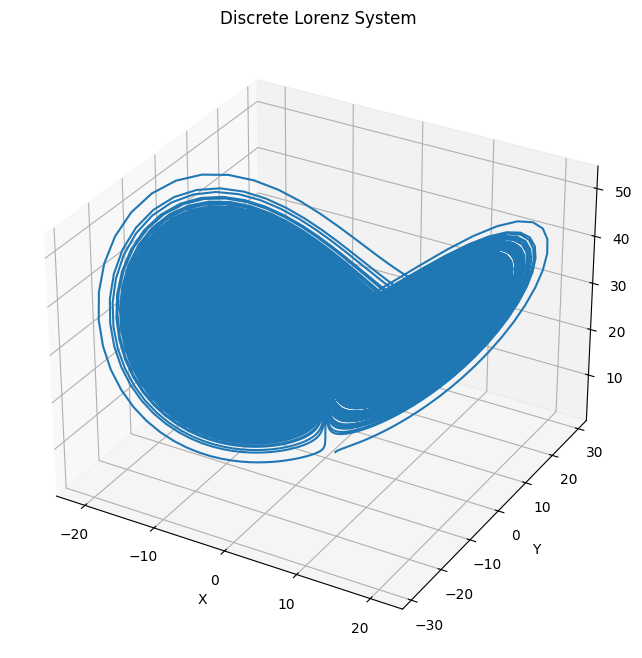

In [123]:
lorenz_3.plot()

In [124]:
large_rnn_history = large_rnn_model.train(training_set)

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 75.7450 - mae: 5.5600 - val_loss: 1.5770 - val_mae: 0.5723
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.8226 - mae: 0.3642 - val_loss: 0.1714 - val_mae: 0.1644
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0845 - mae: 0.1225 - val_loss: 0.0423 - val_mae: 0.0925
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0217 - mae: 0.0769 - val_loss: 0.0212 - val_mae: 0.0752
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0116 - mae: 0.0645 - val_loss: 0.0085 - val_mae: 0.0406
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0082 - mae: 0.0571 - val_loss: 0.0114 - val_mae: 0.0652
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0069 - mae: 0.0550 - val_loss: 0.0057 - val_mae: 0.0404
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0055 - mae: 0.0493 - val_loss: 0.0097 - val_mae: 0.0602
Epoch 9/100
2500/2500 ━

In [125]:
test_state = test_set[0]
predicted_next_state = large_rnn_model.predict_next_state(test_state)
#actual_next_state = lorenz.step(test_state)

print("Predicted next state:", predicted_next_state)
print("Actual next state:", test_state)
print(f"Deviation at first prediction: {euclidean_distance(predicted_next_state, test_state)}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted next state: [ 0.6580801 -3.5771203 26.461332 ]
Actual next state: [ 1.14592102 -3.61548908 27.23276427]
Deviation at first prediction: 0.9135470260502244


In [126]:
num_predictions = 1000
large_rnn_next_1000_predictions = large_rnn_model.generate_predictions(training_set[0], num_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [127]:
final_point_rnn_large = large_rnn_next_1000_predictions[-1]
final_point_actual = test_set[-1]
print(f"Deviation by point {num_predictions}: {euclidean_distance(final_point_rnn_large, final_point_actual)}") 

Deviation by point 1000: 9.754779318577228


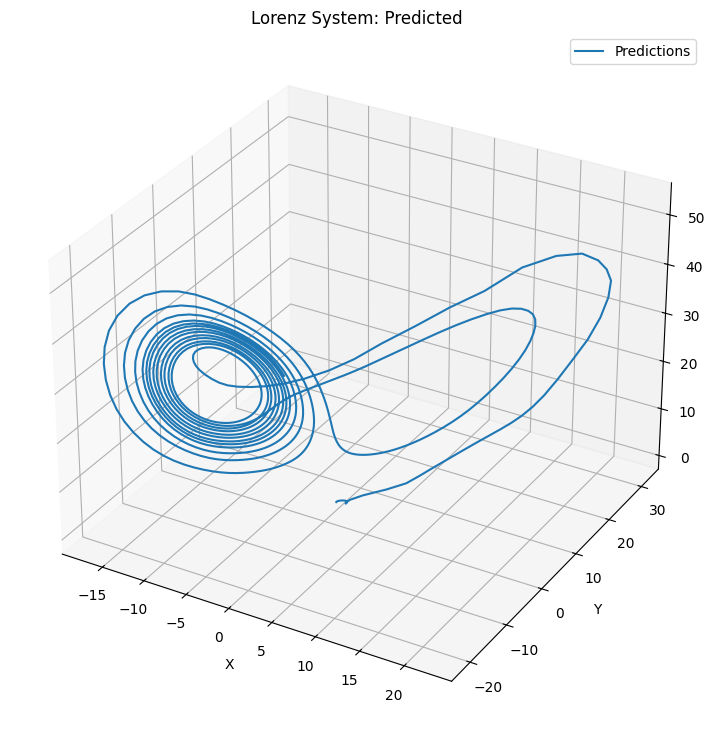

In [128]:
# Plot the predictions
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(large_rnn_next_1000_predictions[:, 0], large_rnn_next_1000_predictions[:, 1], large_rnn_next_1000_predictions[:, 2], label='Predictions')
#ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Predicted')
ax.legend()
plt.show()

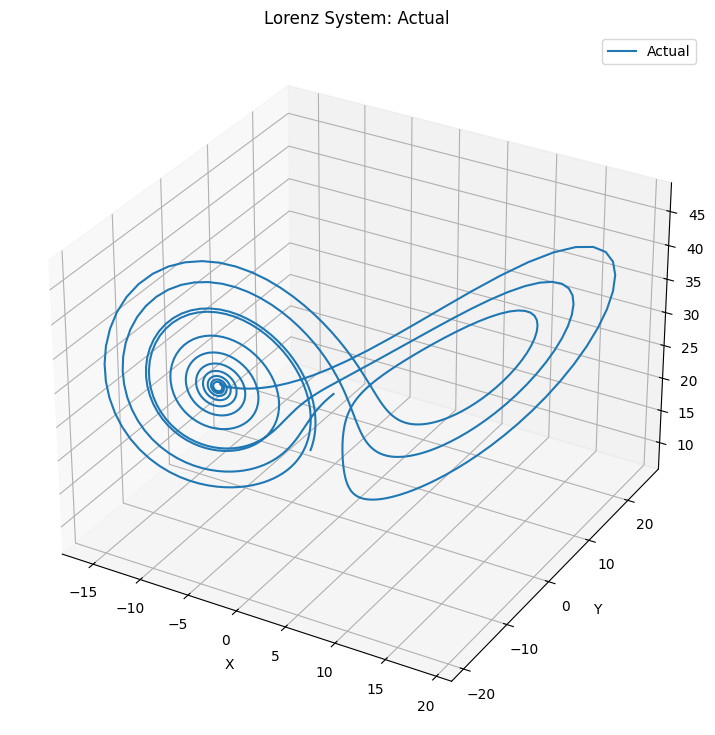

In [129]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Actual')
ax.legend()
plt.show()

In [1]:
## Just for fun lets let it predict further
num_predictions = 3000
large_rnn_next_1000_predictions = large_rnn_model.generate_predictions(training_set[0], num_predictions)

NameError: name 'large_rnn_model' is not defined

In [ ]:
# Plot the predictions
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(large_rnn_next_1000_predictions[:, 0], large_rnn_next_1000_predictions[:, 1], large_rnn_next_1000_predictions[:, 2], label='Predictions')
#ax.plot(test_set[:, 0], test_set[:, 1], test_set[:, 2], label='Actual')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System: Predicted')
ax.legend()
plt.show()

#### Results and Conclusions
Even though we did not accomplish a particularly good model in this project, I think this method of using a nonlinear dynamical system shows some interesting avenues of research regarding NN's and reveals something about their inner workings.  
There are dozens of strategies we can try and avenues to go down. The transparency of the system and data of interest makes this exploration much easier to think about, in my opinion. Forgetting hyperparameter tuning for a moment I would be especially interested in trying neuroevolution with dynamical systems like the Lorenz system.

**References**
https://www.cs.cmu.edu/~epxing/Class/10715/reading/Kornick_et_al.pdf  
Strogatz, Steven, author. Nonlinear Dynamics and Chaos : with Applications to Physics, Biology, Chemistry, and Engineering. Boulder, CO :Westview Press, a member of the Perseus Books Group, 2015  
https://en.wikipedia.org/wiki/Lyapunov_exponent  
https://arxiv.org/pdf/2106.08489  
https://npg.copernicus.org/preprints/npg-2019-23/npg-2019-23.pdf  
https://www.quantamagazine.org/machine-learnings-amazing-ability-to-predict-chaos-20180418/  